# Bayesian analysis of tests with unknown specificity and sensitivity

**Authors:** Andrew Gelman and Bob Carpenter 

Reparametrization: https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html

Data types: https://mc-stan.org/docs/2_19/reference-manual/univariate-data-types-and-variable-declarations.html

We redo the work developed in the article as exercise using `pystan`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sns.set()
plt.rc('mathtext', fontset="cm")

from scipy.special import expit
import pystan as ps

import pickle

ro = np.random.RandomState(1000)

Prevalence estimates (proportion of some characteristic in a population) is sensible to uncertainty in specificicity and sensitivity of the test. Hierarchical modelling is used with bayesian inference to model it in three different models. 

from scipy.special import expit
## Model 1

$$y \sim Bin(n,p),$$
$$p = (1 - \gamma)(1 - \pi) + \delta \pi,$$
$$y_{\gamma} \sim Bin(n_{\gamma}, \gamma),$$
$$y_{\delta} \sim Bin(n_{\delta}, \delta),$$

In [4]:
compiled = True

In [5]:
if compiled: 
    sm = pickle.load(open('../models/prevalence_estimation/pickles/model1.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/prevalence_estimation/stan_codes/model1.stan')
    with open('../models/prevalence_estimation/pickles/model1.pkl', 'wb') as f:
        pickle.dump(sm, f)

## Data

We fit the model by using the data reported in Bendavid et al. (2020a).

In [6]:
n_sample = 3300 
n_spec   = 401
n_sens   = 122

y = 50
y_spec = 399
y_sens = 103

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "n_sens": n_sens
}

## Fitting the model

Consider the following hyperparameters and fit the model. 

In [7]:
tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   1,
      "beta_pi":    1,
})

In [8]:
fit = sm.sampling(data=tests_data, iter=10000, chains=2)

In [9]:
print(fit)

Inference for Stan model: anon_model_0a75e7cf69af7868ab6ce6b4d4cf5344.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
spec         0.99  5.6e-5 3.5e-3   0.99   0.99   0.99    1.0    1.0   3862    1.0
sens         0.84  4.6e-4   0.03   0.77   0.82   0.84   0.86    0.9   5283    1.0
pi           0.01  7.5e-5 4.7e-3 1.1e-3 7.2e-3   0.01   0.01   0.02   3828    1.0
p            0.02  2.0e-5 2.1e-3   0.01   0.01   0.02   0.02   0.02  10702    1.0
spec_prior    0.5  2.9e-3   0.29   0.02   0.24    0.5   0.75   0.98   9947    1.0
sens_prior    0.5  2.9e-3   0.29   0.03   0.26    0.5   0.75   0.98   9758    1.0
pi_prior      0.5  2.9e-3   0.29   0.03   0.24    0.5   0.75   0.98  10162    1.0
p_prior       0.5  2.3e-3   0.23   0.08   0.32    0.5   0.69   0.92   9942    1.0
lp__       -337.7    0.03   1.36 -341.3 -338.4 -337.4 -336.7 -336.2   2

### Posterior checking

Plotting the posterior distributions and scatter plots. 

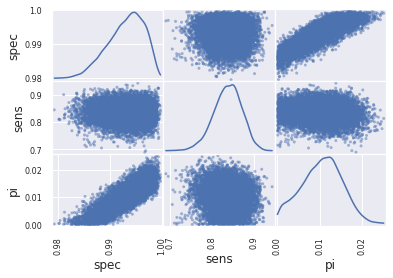

In [10]:
df_trace = pd.DataFrame(fit.extract(['spec', 'sens', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

### Prior checking 

Below we see the iinduced prior distribution on $p$. Despite setting flat priors for all parameters, we observe a non plat prior on $p$. 

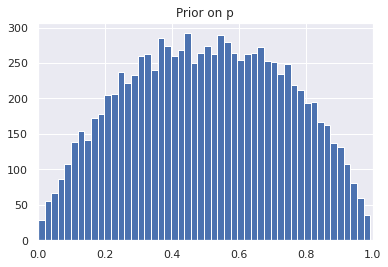

In [11]:
plt.hist(fit.extract()['p_prior'], bins = 50)
plt.title("Prior on p")
plt.xlim((0,1))
plt.show()

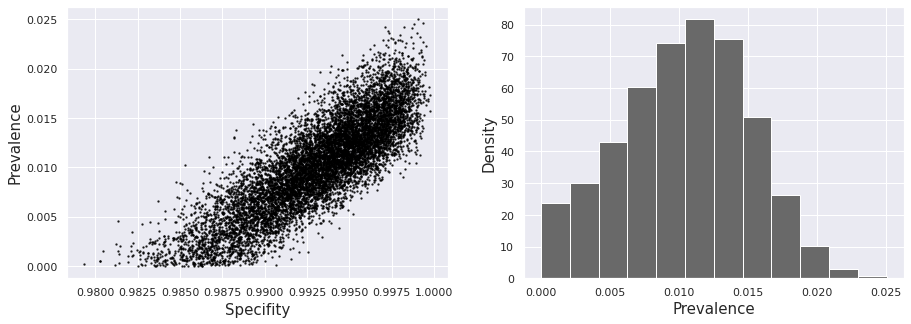

In [13]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].scatter(fit.extract()['spec'], fit.extract()['pi'], s = 2, color = 'black', alpha = 0.7);
ax[0].set_xlabel('Specifity', fontsize = 15)
ax[0].set_ylabel('Prevalence', fontsize = 15)

ax[1].hist(fit.extract()['pi'], color = 'dimgrey', bins = 12, density = True)
ax[1].set_ylabel('Density', fontsize = 15)
ax[1].set_xlabel('Prevalence', fontsize = 15);

plt.savefig('../images/model1_gelman_figure_english.png', bbox_inches='tight',dpi=500)
plt.show()

## Other hyperpriors

We test some other values. 

In [14]:
tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   0.01,
      "beta_pi":    0.19,
})

fit = sm.sampling(data=tests_data, iter=10000, chains=2, control=dict(adapt_delta=0.96))
print(fit)

Inference for Stan model: anon_model_0a75e7cf69af7868ab6ce6b4d4cf5344.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

             mean se_mean     sd     2.5%     25%     50%     75%  97.5%  n_eff   Rhat
spec         0.99  1.0e-4 3.1e-3     0.98    0.98    0.99    0.99    1.0    954    1.0
sens         0.84  6.2e-4   0.03     0.77    0.82    0.84    0.86    0.9   2828    1.0
pi         1.5e-3  1.4e-4 3.5e-3  4.4e-16 3.6e-12  5.8e-8  3.3e-4   0.01    670   1.01
p            0.01  2.3e-5 2.0e-3     0.01    0.01    0.01    0.02   0.02   7424    1.0
spec_prior    0.5  2.8e-3   0.29     0.02    0.25     0.5    0.76   0.98  10663    1.0
sens_prior    0.5  2.9e-3   0.29     0.02    0.25     0.5    0.74   0.98   9875    1.0
pi_prior     0.05  2.1e-3    0.2 1.7e-161 3.2e-60 4.8e-29 2.6e-11   0.97   9535    1.0
p_prior       0.5  2.8e-3   0.29     0.03    0.25     0.5    0.74   0.97  10631    1.0
lp__       -333.5    0.02 

Changing the prior distribution on $\pi$ (reduced the mean by 10), the induced on $p$ is more uniform! 

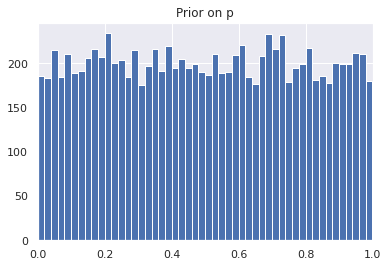

In [15]:
plt.hist(fit.extract()['p_prior'], bins = 50)
plt.title("Prior on p")
plt.xlim((0,1))
plt.show()

## Model 2

Now we adapt to a hierarchical model

$$
logit(\gamma_j) \sim normal(\mu_{\gamma}, \sigma_{\gamma}) \\
logit(\delta_j) \sim normal(\mu_{\delta}, \sigma_{\delta})
$$

where $j=1,...,J$ are studies for each parameter. 

**Remark:** The reparameterization of `logit_spec` and `logit_sens` with offset and multiplier, we obtain a non-central distribution wahat is computationally better. 

In [19]:
compiled = True

In [20]:
if compiled: 
    sm2 = pickle.load(open('../models/prevalence_estimation/pickles/model2.pkl', 'rb'))
else: 
    sm2 = ps.StanModel(file = '../models/prevalence_estimation/stan_codes/model2.stan')
    with open('../models/prevalence_estimation/pickles/model2.pkl', 'wb') as f:
        pickle.dump(sm2, f)

## Data

First we simulate the data based on the second model.

In [21]:
n_sample = 100

J_spec   = 5
n_spec   = np.array([10,30,15,20,40])
J_sens   = 5
n_sens   = np.array([10,30,15,20,40])

mu_spec = np.array([2.5, 3.5, 2.2, 4.1, 3.2])
mu_sens = np.array([2.5, 3.5, 2.2, 4.1, 3.2])

sigma_spec = np.array([0.5, 0.2, 0.6, 0.1, 0.2])
sigma_sens = np.array([0.5, 0.2, 0.6, 0.1, 0.2])

spec = expit(ro.normal(loc = mu_spec, scale = sigma_spec))
sens = expit(ro.normal(loc = mu_spec, scale = sigma_spec))

pi   = 0.01
p    = (1 - spec[0])*(1 - pi) + sens[0]*pi

y      = ro.binomial(n=n_sample, p=p)
y_spec = ro.binomial(n=n_spec, p=spec)
y_sens = ro.binomial(n=n_sens, p=sens)

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "J_spec": J_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "J_sens": J_sens,
    "n_sens": n_sens
}

## Fitting the model

Consider the following hyperparameters and fit the model. 

In [22]:
tests_data.update({
      "alpha_pi"             : 0.1,
      "beta_pi"              : 1.9,  
      "mean_hyper_mean_spec" : 3,
      "mean_hyper_mean_sens" : 3, 
      "sd_hyper_mean_spec"   : 2,
      "sd_hyper_mean_sens"   : 2,
      "sd_hyper_sd_spec"     : 1,
      "sd_hyper_sd_sens"     : 1,
})

In [23]:
fit2 = sm2.sampling(data=tests_data, iter=3000, chains=4, control=dict(adapt_delta=0.95))

In [24]:
print(fit2)

Inference for Stan model: anon_model_f03490079dc5cd0799978ea307a407af.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                        mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi                      0.02  5.7e-4   0.03 5.4e-14 5.9e-7 4.4e-4   0.02   0.11   2888    1.0
mean_logit_spec         3.76    0.01   0.78    2.44   3.21   3.67   4.22   5.53   3225    1.0
mean_logit_sens         2.79    0.01   0.71     1.5   2.31   2.74   3.21    4.3   2990    1.0
sd_logit_spec           1.07    0.01   0.58     0.1   0.65   1.03   1.44   2.35   2376    1.0
sd_logit_sens           1.23    0.01   0.57    0.24   0.83   1.18   1.58   2.49   2480    1.0
logit_spec[1]           2.62    0.01   0.57     1.8   2.25   2.51   2.86   4.09   2462    1.0
logit_spec[2]           4.38    0.02   1.25     2.6    3.5   4.16   5.01   7.43   4267    1.0
logit_spec[3]           4.18    0.02   1.26    2.34    3.3 

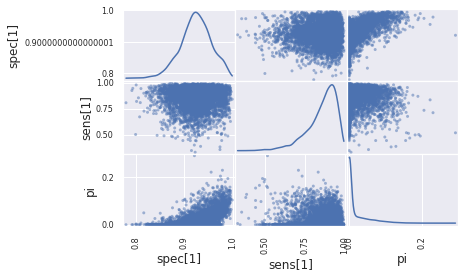

In [25]:
df_trace = pd.DataFrame(fit2.extract(['spec[1]', 'sens[1]', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

## Other hyperpriors

In [26]:
tests_data.update({
      "alpha_pi"             : 0.001,
      "beta_pi"              : 0.019,  
      "mean_hyper_mean_spec" : 0.5,
      "mean_hyper_mean_sens" : 0.5, 
      "sd_hyper_mean_spec"   : 0.5,
      "sd_hyper_mean_sens"   : 0.5,
      "sd_hyper_sd_spec"     : 0.5,
      "sd_hyper_sd_sens"     : 0.5,
})

fit2 = sm2.sampling(data=tests_data, iter=2000, chains=4, control=dict(adapt_delta=0.95, max_treedepth=12))
print(fit2)

Inference for Stan model: anon_model_f03490079dc5cd0799978ea307a407af.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd    2.5%     25%      50%      75%  97.5%  n_eff   Rhat
pi                    2.0e-3  1.6e-4 9.9e-3 2.2e-16 6.7e-13   2.8e-9   9.9e-6   0.02   3867    1.0
mean_logit_spec         1.89    0.01   0.46     0.9    1.58     1.94     2.23   2.68   1133    1.0
mean_logit_sens          1.5    0.01   0.41    0.66    1.24     1.52     1.78   2.24   1213    1.0
sd_logit_spec           0.85    0.01   0.45    0.06    0.51     0.86     1.16   1.73    992    1.0
sd_logit_sens           0.87    0.01   0.36    0.15    0.63     0.86     1.11   1.61   1096    1.0
logit_spec[1]           2.23  4.4e-3    0.3    1.67    2.03     2.22     2.42   2.85   4575    1.0
logit_spec[2]           3.06    0.02   0.78    1.92    2.49     2.92     3.48   4.97   2080    1.0
logit_spec[3]      

## Considering bivariate beta distribution

Taking the bivariate form discussed in the notebook `bivariate_beta.ipynb`, we modified the first model a little. 

In [29]:
compiled = True

In [30]:
if compiled: 
    sm = pickle.load(open('../models/prevalence_estimation/pickles/model1_bivariate.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/prevalence_estimation/stan_codes/model1_bivariate_const.stan')
    with open('../models/prevalence_estimation/pickles/model1_bivariate.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data

In [31]:
n_sample = 3300 
n_spec   = 401
n_sens   = 122

y = 50
y_spec = 399
y_sens = 103

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "n_sens": n_sens
}

### Fitting the model

In [32]:
tests_data.update({
      "alpha": [10,1,1,1],
      "alpha_pi":   0.01,
      "beta_pi":    0.19,
})

fit = sm.sampling(data=tests_data, iter=10000, chains=1, control=dict(adapt_delta=0.9))
print(fit)

Inference for Stan model: anon_model_46a5b7cd86748b5dc4d941f7171c5fe4.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

       mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
U[1]   0.84  7.8e-4   0.03    0.77    0.82    0.84   0.87    0.9   1642    1.0
U[2]   0.14  7.9e-4   0.03    0.09    0.12    0.14   0.16   0.21   1602    1.0
U[3] 6.9e-3  9.4e-5 4.3e-3  2.9e-4  3.3e-3  6.7e-3   0.01   0.02   2091    1.0
U[4] 7.4e-3  9.8e-5 4.3e-3  3.8e-4  3.7e-3  7.4e-3   0.01   0.02   1901    1.0
pi   4.5e-4  4.8e-5 1.4e-3 2.2e-16 1.6e-12 10.0e-9 2.3e-5 5.4e-3    839    1.0
spec   0.99  4.8e-5 2.1e-3    0.98    0.98    0.99   0.99   0.99   1896    1.0
sens   0.85  7.7e-4   0.03    0.78    0.83    0.85   0.87    0.9   1645    1.0
p      0.01  2.9e-5 2.0e-3    0.01    0.01    0.01   0.02   0.02   4740    1.0
lp__ -341.5    0.04   1.36  -345.1  -342.1  -341.1 -340.5 -339.9   1411    1.0

Samples were drawn 

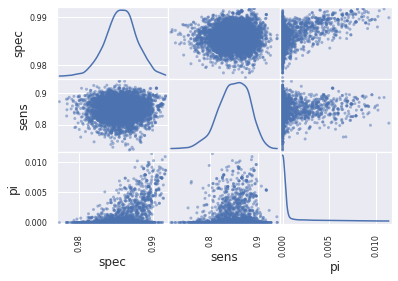

In [33]:
df_trace = pd.DataFrame(fit.extract(['spec', 'sens', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()